Modified heavily from ICESat-2 and GEDI Crossovers by David Shean, November 22, 2021

In [ ]:
from sliderule import sliderule, earthdata, h5, raster, icesat2, gedi
import geopandas as gpd
import numpy as np
import pandas as pd
import ee
import geemap
from datetime import datetime
from datetime import timedelta
sliderule.init()

# Step 1: See if your AOI is ever not snowy, and if so, save those dates

In [2]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

In [3]:
aoi_filename = 'https://raw.githubusercontent.com/ICESAT-2HackWeek/dzdt/main/sites/ellesmere.geojson'

In [5]:
geometry = geemap.geojson_to_ee(aoi_filename)

Downloading...
From: https://raw.githubusercontent.com/ICESAT-2HackWeek/dzdt/main/sites/ellesmere.geojson
To: /tmp/1ca85ced-89c1-4c25-ace8-3099b54ee670.geojson
319B [00:00, 877kB/s]                    


## Collect NDSI snow cover for the AOI

In [72]:
big_dict = {}

year_list = ['18', '19', '20', '21', '22', '23']

for i, y in enumerate(year_list):
    collection = (ee.ImageCollection('MODIS/061/MOD10A1')
                .filterBounds(geometry)
                .filter(ee.Filter.date(f'20{y}-05-01', f'20{y}-09-30'))
                .select('NDSI_Snow_Cover')
                # .first()
              )
    # Function to calculate mean for an image and add it as a property
    def calculate_mean(image):
        mean = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=30  # Resolution of Landsat data in meters
        )
        return image.set('mean', mean)

    # Map the function over the ImageCollection
    collection_with_mean = collection.map(calculate_mean)

    # Initialize an empty dictionary to store results
    mean_dict = {}

    # Iterate through the ImageCollection and populate the dictionary
    for image in collection_with_mean.getInfo()['features']:
        image_date_ms = image['properties']['system:time_start']
        image_date = datetime.utcfromtimestamp(image_date_ms / 1000).strftime('%Y-%m-%d')
        mean_value = image['properties']['mean']['NDSI_Snow_Cover']  # Assuming B2 band, modify as needed
        mean_dict[image_date] = mean_value
        
    big_dict.update(mean_dict)

In [159]:
snograph = pd.DataFrame([big_dict]).T
snograph['snow_cover'] = snograph.values
snograph['date'] = pd.to_datetime(snograph.index)
snograph['nice_date'] = snograph['date'].dt.date


<AxesSubplot: xlabel='date'>

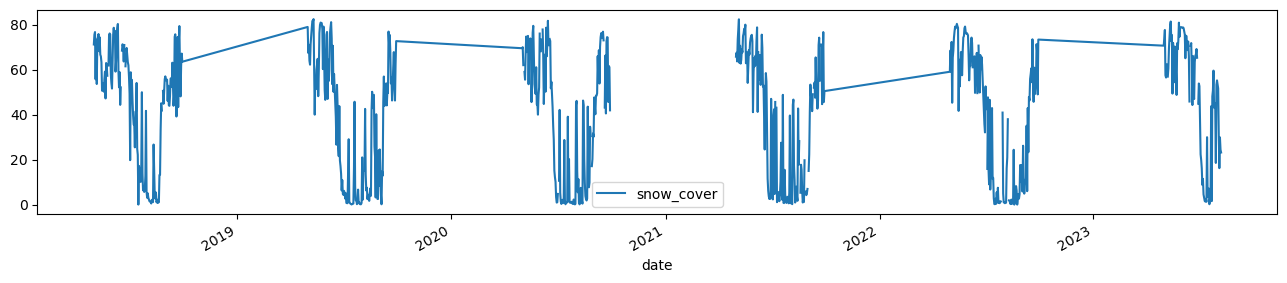

In [116]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,3))
snograph.plot(x='date', y='snow_cover', ax=ax)

In [130]:
# Just wrap each list element in str() later
low_snow_list = snograph[snograph['snow_cover']<10]['date'].dt.date.to_list()
len(low_snow_list)

216

# Get ATL06 data

Holla @ [Jonathan Markle](https://j3d.space/) for this next snippet to get a bunch of datat without hitting `earthdata` limits

In [129]:
aoi = gpd.GeoDataFrame.from_file(aoi_filename, crs='EPSG:4326')
region = sliderule.toregion(aoi)

In [143]:
# Build ATL06 Request Parameters
parms_19 = {
    "poly": region["poly"],
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 7.0,
    "cnt": 10,
    "len": 20.0,
    "res": 10.0,
    "t0":'2019-06-15',
    "t1":'2019-09-15',
}

parms_20 = {
    "poly": region["poly"],
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 7.0,
    "cnt": 10,
    "len": 20.0,
    "res": 10.0,
    "t0":'2020-06-15',
    "t1":'2020-09-15',
}

parms_21 = {
    "poly": region["poly"],
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 7.0,
    "cnt": 10,
    "len": 20.0,
    "res": 10.0,
    "t0":'2021-06-15',
    "t1":'2021-09-15',
}

parms_22 = {
    "poly": region["poly"],
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 7.0,
    "cnt": 10,
    "len": 20.0,
    "res": 10.0,
    "t0":'2022-06-15',
    "t1":'2022-09-15',
}


# Make ATL06 requests, trying to avoid sliderule resource limits
print('Getting 2019 data')
atl06_19 = icesat2.atl06p(parms_19)

print('Getting 2020 data')
atl06_20 = icesat2.atl06p(parms_20)

print('Getting 2021 data')
atl06_21 = icesat2.atl06p(parms_21)

print('Getting 2022 data')
atl06_22 = icesat2.atl06p(parms_22)


Getting 2019 data
Getting 2020 data
Getting 2021 data
Getting 2022 data


In [166]:
gdf_all = pd.concat([atl06_19, atl06_20, atl06_21, atl06_22])

In [167]:
# I didn't like that the timestamp was the index 
gdf_all = gdf_all.reset_index()

In [168]:
gdf_all['time_date'] = gdf_all['time'].dt.date

## Only keep "low-snow" days

In [170]:
matches = pd.merge(gdf_all, snograph[snograph['snow_cover']<10], left_on='time_date', right_on='nice_date')

In [198]:
matches[['time', 'nice_date', 'time_date']]

time   nice_date   time_date
0      2019-07-12 19:45:27.430117888  2019-07-12  2019-07-12
1      2019-07-12 19:45:27.431524608  2019-07-12  2019-07-12
2      2019-07-12 19:45:27.432930560  2019-07-12  2019-07-12
3      2019-07-12 19:45:27.434339072  2019-07-12  2019-07-12
4      2019-07-12 19:45:27.435746560  2019-07-12  2019-07-12
...                              ...         ...         ...
332653 2022-09-10 12:39:31.697084928  2022-09-10  2022-09-10
332654 2022-09-10 12:39:31.699912704  2022-09-10  2022-09-10
332655 2022-09-10 12:39:31.701324032  2022-09-10  2022-09-10
332656 2022-09-10 12:39:31.702735616  2022-09-10  2022-09-10
332657 2022-09-10 12:39:31.704145152  2022-09-10  2022-09-10

[332658 rows x 3 columns]

Hell yeah

In [173]:
gdf = matches

<AxesSubplot: >

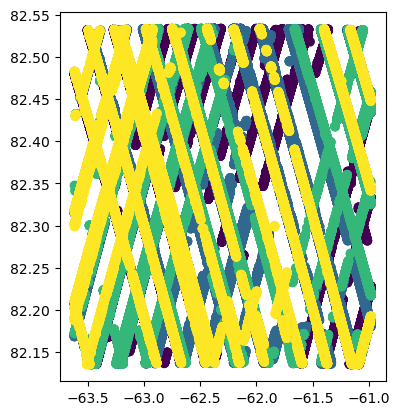

In [174]:
# Take a quick peek to see how many tracks might cross!
# Note this will take forever if you have a ton of points
gdf.plot(column='cycle')

# Find overlapping points within buffer
Now I'm creating a radius for the points, which involves some reprojection

In [175]:
# A little script I have to get the EPSG string to give to the to_crs function
epsg_string = int(32700-(np.round((45+gdf.geometry.y.values.mean())/90,0)*100)+np.round((183+gdf.geometry.x.values.mean())/6,0))

In [176]:
# Now generate a buffer around each point and make a new dataframe for that 
radius = 7 #radius in meters
gdf_utm = gdf.to_crs(f'EPSG: {epsg_string}')
gdf_crop_poly_geom = gdf_utm.geometry.buffer(radius)
# gdf_crop_poly_geom.to_crs('EPSG:4326').plot()
gdf_crop_poly = gpd.GeoDataFrame(gdf.copy(), geometry=gdf_crop_poly_geom).to_crs('EPSG:4326')
gdf_crop_poly.shape

(332658, 21)

In [177]:
# This is a function that I am pretty sure grabs points that intersect with
# a buffer and calculate the temporal difference between point and buffer
def xover_proc(df):
    #Convert back to point geometry
    df['geometry'] = df.centroid.geometry
    df['dt_diff'] = df['time_left'] - df['time_right']   
    #Remove any self intersections
    idx = (df.index != df['time_right'])
    return df.loc[idx]


In [178]:
# This is new for me! You can do a spatial join on a single geodataframe to find
# the points that intersect with the buffers 
# This creates multiples
xover = gpd.sjoin(
    gdf_crop_poly,
    gdf_crop_poly,
)

In [179]:
# Now calculate the height differences for intersection areas
# Note that there will be pairs of differences - the positive and negatve
# as you subtract an earlier track from a later track and vice versa
xover['h_mean_diff'] = xover['h_mean_left'] - xover['h_mean_right']

# And do the function that gets the temporal difference
# I don't think the centroid error is that important here
xover = xover_proc(xover)


/tmp/ipykernel_623/2390359495.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['geometry'] = df.centroid.geometry


OK so what have we done??

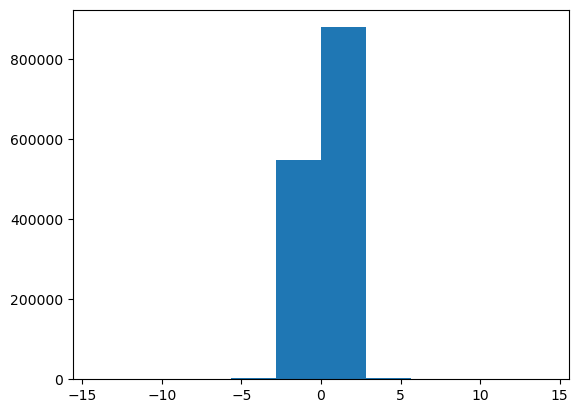

In [180]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
data = ax.hist(xover['h_mean_diff'].values)

# Temporal threshold

In [318]:
# dateformat = '%Y-%m-%d'
# str(xover["time_left"].dt.date.iloc[xover["time_left"].dt.date.value_counts().max()])

In [319]:
# What are the dates of these cycles?
xover.groupby('cycle_left')['time_left'].mean()

cycle_left
4    2019-08-12 06:23:32.057687808
8    2020-07-30 04:43:28.744448000
12   2021-08-08 00:02:33.341934336
16   2022-08-12 08:19:44.196054016
Name: time_left, dtype: datetime64[ns]

In [320]:
ndays = 30
dt_thresh = pd.Timedelta(days=ndays)
dt_thresh

Timedelta('30 days 00:00:00')

In [321]:
# Make sure the time between collection is more than 30 days
xover_thresh = xover.loc[xover['dt_diff'].abs() > dt_thresh]

In [322]:
# And now get rid of "doubles" by looking at only positive timedeltas
xover_thresh = xover_thresh[xover_thresh['dt_diff'] > pd.Timedelta(0)]

In [323]:
# Look at the unique combinations of cycle pairs for the crossovers
xover_thresh.groupby(['cycle_left', 'cycle_right']).size().reset_index().rename(columns={0:'count'})

cycle_left  cycle_right  count
0           4            4    188
1           8            4  77504
2           8            8    330
3          12            4  28516
4          12            8  29775
5          12           12    197
6          16            4  36348
7          16            8  34545
8          16           12  30038
9          16           16    137

# Google!

In [190]:
exploring = gpd.GeoDataFrame(xover_thresh.filter(['h_mean_diff','cycle_left','cycle_right']), geometry=xover_thresh.geometry).to_crs('EPSG:4326')

## Get images for the dates you're interested in 

In [325]:
# Bring in images from the dates with the most ICESat-2 records
top_10_dates = xover_thresh['time_left'].dt.date.value_counts()[0:10].index.to_list()

In [212]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [214]:
Map.add_basemap('SATELLITE') # <-- this adds a layer called 'Google Satellite'
Map.layer_opacity(name='Google Satellite', opacity=0.5)
Map.setCenter(exploring.geometry.x.mean(), exploring.geometry.y.mean(), zoom=7);
# Map.addLayer(gtx_feature,{'color': 'red'},'ground track')

In [231]:
collection_name1 = 'COPERNICUS/S2_SR_HARMONIZED'  # Landsat 8 earth engine collection 
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T2
collection = ee.ImageCollection(collection_name1)
point_of_interest = ee.Geometry.Point(exploring.geometry.x.mean(), exploring.geometry.y.mean())
collection = collection.filterBounds(point_of_interest)

In [248]:
collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
point_of_interest = ee.Geometry.Point(exploring.geometry.x.mean(), exploring.geometry.y.mean())
collection = collection.filterBounds(point_of_interest)
days_buffer_imagery = 1
for date in top_10_dates:
    datetime_requested = datetime.strptime(str(date), dateformat)
    search_start = (datetime_requested - timedelta(days=days_buffer_imagery)).strftime(dateformat)
    search_end = (datetime_requested + timedelta(days=days_buffer_imagery)).strftime(dateformat)
    filtered_collection = collection.filterDate(search_start, search_end).sort('system:time_start') 
    myImage = filtered_collection.reduce(ee.Reducer.median())

    try:
        myImage_RGB = myImage.select('B4_median', 'B3_median', 'B2_median')   
        vis_params = {'min': 0.0, 'max': 10000, 'opacity': 1.0, 'gamma': 1.5}
        Map.addLayer(myImage_RGB, vis_params, name=str(date))
    except Exception:
        print(f'No image for {date}')

# Ok, I have days I want

OK so I want to difference 2020-07-29 from 2022-07-26 based on the pictures I just loaded in. 

In [326]:
xover_thresh['nice_time_left'] = xover_thresh['time_left'].dt.date

In [329]:
date_after = '2022-07-26'
date_before = '2020-07-29'
# xover_thresh[xover_thresh['nice_time_left'] == datetime.strptime(date_after, '%Y-%m-%d').date()]['nice_date_right'].value_counts()
plot_me = (xover_thresh[(xover_thresh['time_left'].dt.date == datetime.strptime(date_after, '%Y-%m-%d').date()) 
                        & (xover_thresh['time_right'].dt.date == datetime.strptime(date_before, '%Y-%m-%d').date())])

In [312]:
plot_me.filter(['h_mean_diff','geometry']).explore(column='h_mean_diff')

## And now add those points to the Earth Engine map

In [313]:
ground_track_coordinates = list(zip(plot_me.geometry.x, plot_me.geometry.y))
point_list = ee.List(ground_track_coordinates)
point_list
ground_track_projection = 'EPSG:4326' # <-- this specifies that our data longitude/latitude in degrees [https://epsg.io/4326]

features = []
for i, xy in enumerate(ground_track_coordinates):
    point = ee.Geometry.Point(xy,proj=ground_track_projection,geodesic=True).buffer(10)
    feature = ee.Feature(point).set({'h_mean_diff' : plot_me['h_mean_diff'].tolist()[i] })
    features.append(feature)

# Create a FeatureCollection object
gtx_feature = ee.FeatureCollection(features)

In [314]:
empty = ee.Image().byte()
offsets = empty.paint(**{
  'featureCollection': gtx_feature,
  'color': 'h_mean_diff',
    'width' : 4,
    })
fillspalette = ['red','yellow','green']
Map.addLayer(offsets, {'palette': fillspalette, 'min': -1.0, 'max': 1.0}, 'offset', True, 1.0)

# Slope?

<AxesSubplot: xlabel='dh_fit_dx_left', ylabel='h_mean_diff'>

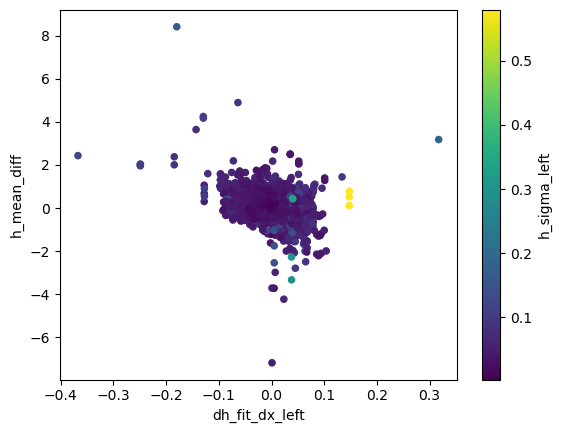

In [317]:
plot_me.plot.scatter(x='dh_fit_dx_left', y='h_mean_diff', c='h_sigma_left')